In [1]:
if("quantmod" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("quantmod")}
if("tidyquant" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("tidyquant")}

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(janitor)
library(scales)

library(tidyquant)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: lubridate


Attaching pa

In [3]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)

# Project Proposal


**Yiou Long, Nikko Dumrique, Andres Zepeda, Medha Singh**

`Monday November 1st 2021`

### Introduction

***!!!DELETE***

Begin by providing some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.

Clearly state the question you will try to answer with your project. Your question should involve one random variable of interest (the response) and one or more explanatory variables. Of the response variable, explain whether your project is focused on prediction, inference, or both.

Identify and describe the dataset that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need, in fact, exploring how the different variables in the dataset affect your model, is a crucial part of the project.

Also, be sure to frame your question/objectives in terms of what is already known in the literature. Be sure to include at least two scientific publications that can help frame your study (you will need to include these in the References section).

### Exploratory Data Analysis (EDA)

***!!!DELETE***

In this section, you will:

Demonstrate that the dataset can be read from the web into R.
Clean and wrangle your data into a tidy format.
Plot the relevant raw data, tailoring your plot in a way that addresses your question.
make sure to explore the association of the explanatory variables with the response.
your Exploratory Data Analysis (EDA) must be comprehensive with high quality plots.
Any summary tables that is relevant to your analysis.
Be sure to not print output that takes up a lot of screen space.

In [4]:
#pulling data from Yahoo finance API
intel_index <- tq_get(c('INTC','WAF.DE','AMD','AAPL','DELL', "MMM"),
               from = "2014-09-01",
               to = "2019-03-01",
               get = "stock.price")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip



In [5]:
head(intel_index)
tail(intel_index)
nrow(intel_index)

symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INTC,2014-09-02,34.76,34.91,34.43,34.57,32094800,28.41110
INTC,2014-09-03,34.82,34.88,34.45,34.57,26668800,28.41110
INTC,2014-09-04,34.53,35.09,34.52,34.91,27632400,28.69053
INTC,2014-09-05,34.92,35.12,34.83,35.00,20841900,28.76449
INTC,2014-09-08,34.96,35.56,34.88,35.33,24859600,29.03571
INTC,2014-09-09,35.29,35.29,34.85,34.91,22333100,28.69053


symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMM,2019-02-21,208.16,209.11,207.25,207.77,1737600,190.6579
MMM,2019-02-22,207.77,209.66,207.15,209.35,1534200,192.1078
MMM,2019-02-25,210.47,211.35,210.34,210.58,2183500,193.2365
MMM,2019-02-26,210.58,211.59,209.37,209.38,1671300,192.1353
MMM,2019-02-27,209.60,209.69,208.16,209.03,1540600,191.8141
MMM,2019-02-28,209.05,209.05,206.96,207.39,2121700,190.3092


[1] 6109

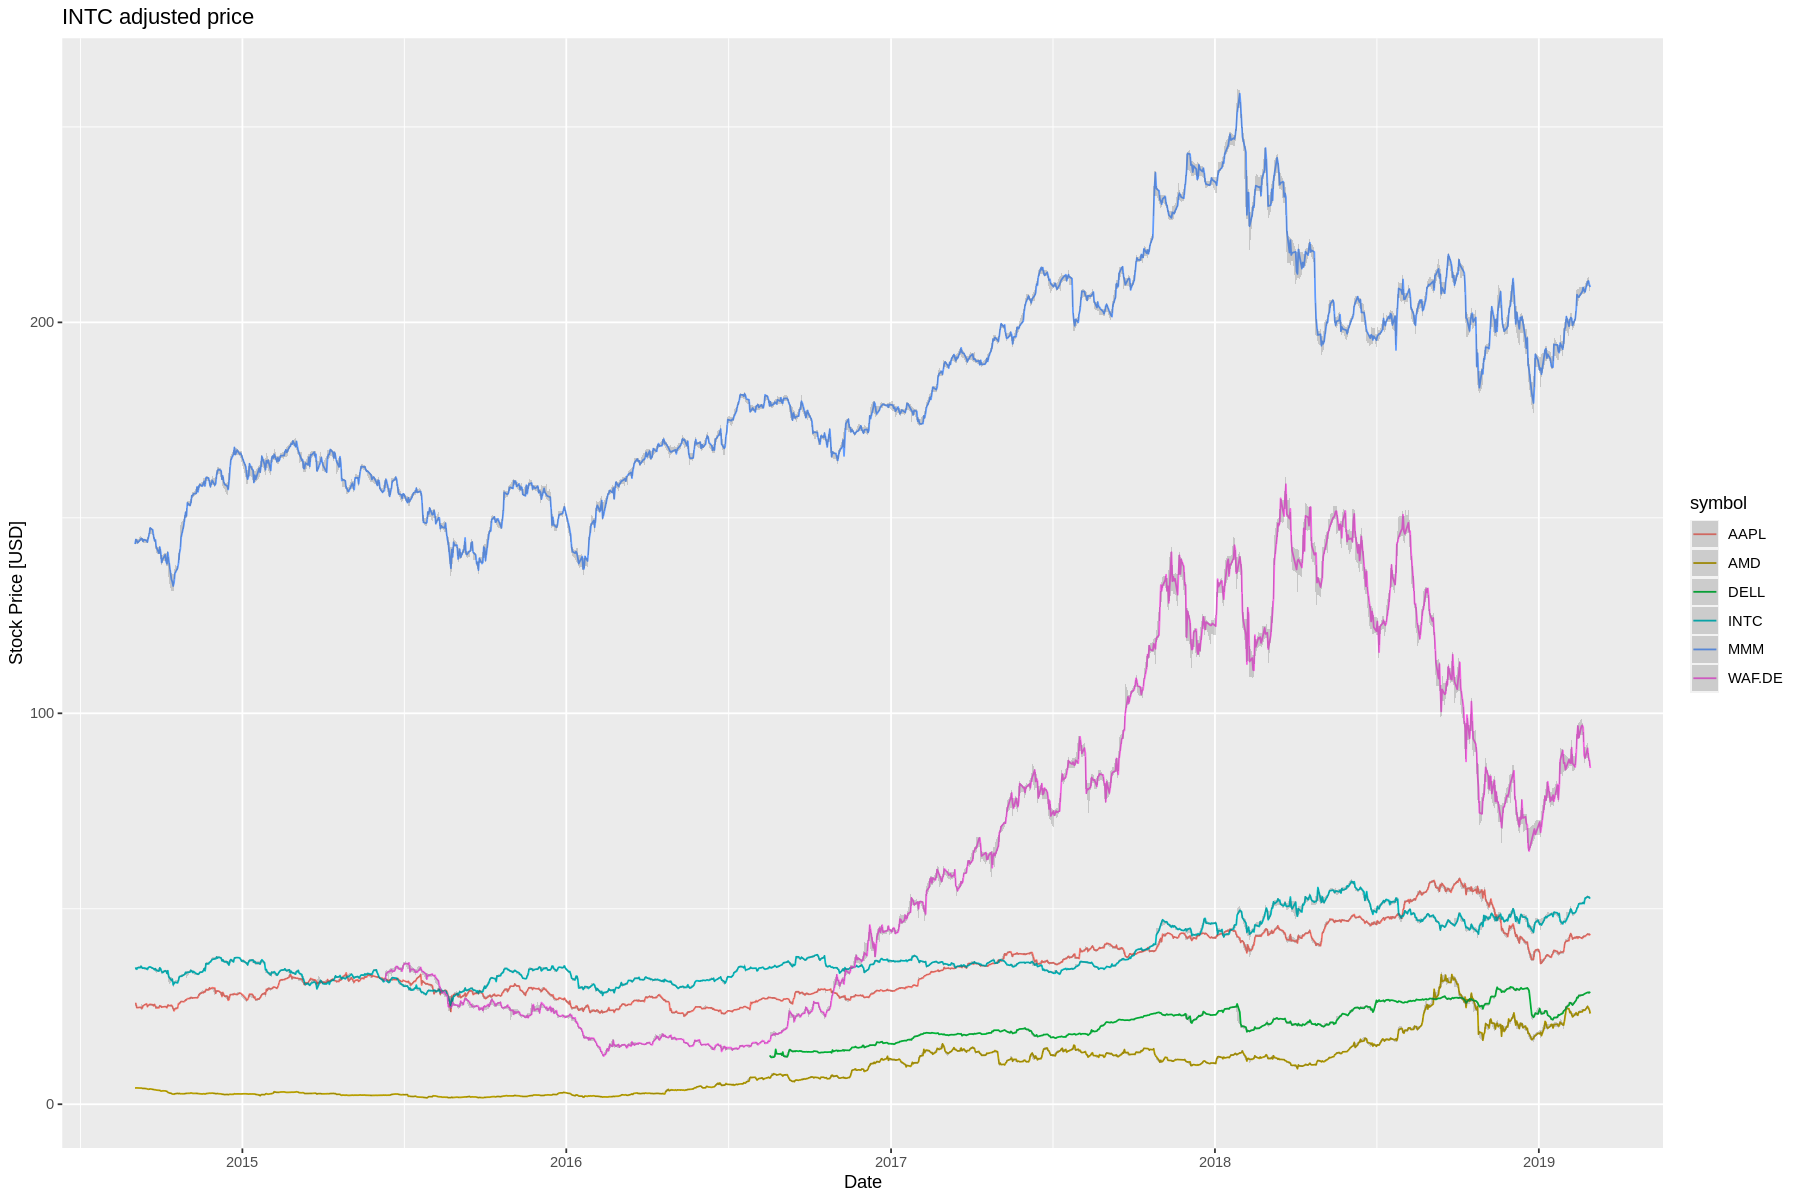

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)

#plotting the open price of each stock. 
#The grey region around the lines indicate the high and low prices of that day
intel_plt = intel_index |> 
    group_by(symbol) |>
    mutate(symbol = factor(symbol)) |>
    ggplot() +
    geom_line(aes(x = date, 
                  y = open,
                  color = symbol)
             ) + 
    geom_ribbon(aes(x = date,
                    y = open,
                    ymin=low,
                    ymax=high,
                    color = symbol),
                alpha = 0.2, linetype=0
               ) +
    ggtitle('INTC adjusted price') + 
    xlab('Date') +
    ylab('Stock Price [USD]')
intel_plt

As shown, the grey ribbon depicting the high and low of that days stock price is tightly bounding the opening price. This is expected as `open, high, low, close, and adjusted` essentially depict the same data (with some noise factor). Therefore to reduce complexity of our model, we shall utilize just the adjusted price.

In [7]:
intel_index = intel_index |> 
    select(symbol, date, adjusted, volume) |>
    pivot_wider(names_from = 'symbol', 
                values_from = c('volume', 'adjusted')) |> 
    mutate(month = month(date))

In [8]:
#standardizing data and removing NA observations
intel_index[,2:13] = intel_index[,2:13] |>
    mutate_all(~(scale(.) %>% as.vector)) 

In [9]:
#filter out observations with NA
intel_index = intel_index[complete.cases(intel_index),]
head(intel_index)
nrow(intel_index)

date,volume_INTC,volume_WAF.DE,volume_AMD,volume_AAPL,volume_DELL,volume_MMM,adjusted_INTC,adjusted_WAF.DE,adjusted_AMD,adjusted_AAPL,adjusted_DELL,adjusted_MMM,month
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-17,-0.7209934,-0.92066332,-0.7865773,-0.6958947,-0.6859714,-0.9124829,-0.4134626,-1.153196,-0.3671756,-0.8173022,-1.961177,-0.1439943,8
2016-08-18,-0.8985088,0.04563529,-0.3923705,-0.8670596,-0.5301094,-1.1801923,-0.4192073,-1.109062,-0.3160777,-0.8210099,-1.976696,-0.1650678,8
2016-08-19,-0.8708893,-0.46422334,0.6364369,-0.6952803,-0.2207986,-0.9651146,-0.3881767,-1.101505,-0.2337533,-0.8135945,-1.930141,-0.1519356,8
2016-08-22,-0.9935481,-0.70116378,-0.1433024,-0.6723267,-0.4802469,-0.9343468,-0.3743845,-1.119685,-0.2394308,-0.8361041,-1.920830,-0.1684282,8
2016-08-23,-0.7131496,-0.76925633,-0.4678201,-0.9039703,-0.5597373,-1.0734449,-0.3697882,-1.112785,-0.2266563,-0.8271005,-1.837031,-0.1470498,8
2016-08-24,-0.8770464,-0.68337785,-0.5742411,-0.7812360,-0.4510646,-1.1315178,-0.3985200,-1.111471,-0.2607216,-0.8488157,-1.799787,-0.1580429,8


[1] 627

In [10]:
#Correlation between response variables
index_correlation = intel_index[,2:14] |> 
    ggpairs(progress = FALSE) +
    theme (
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

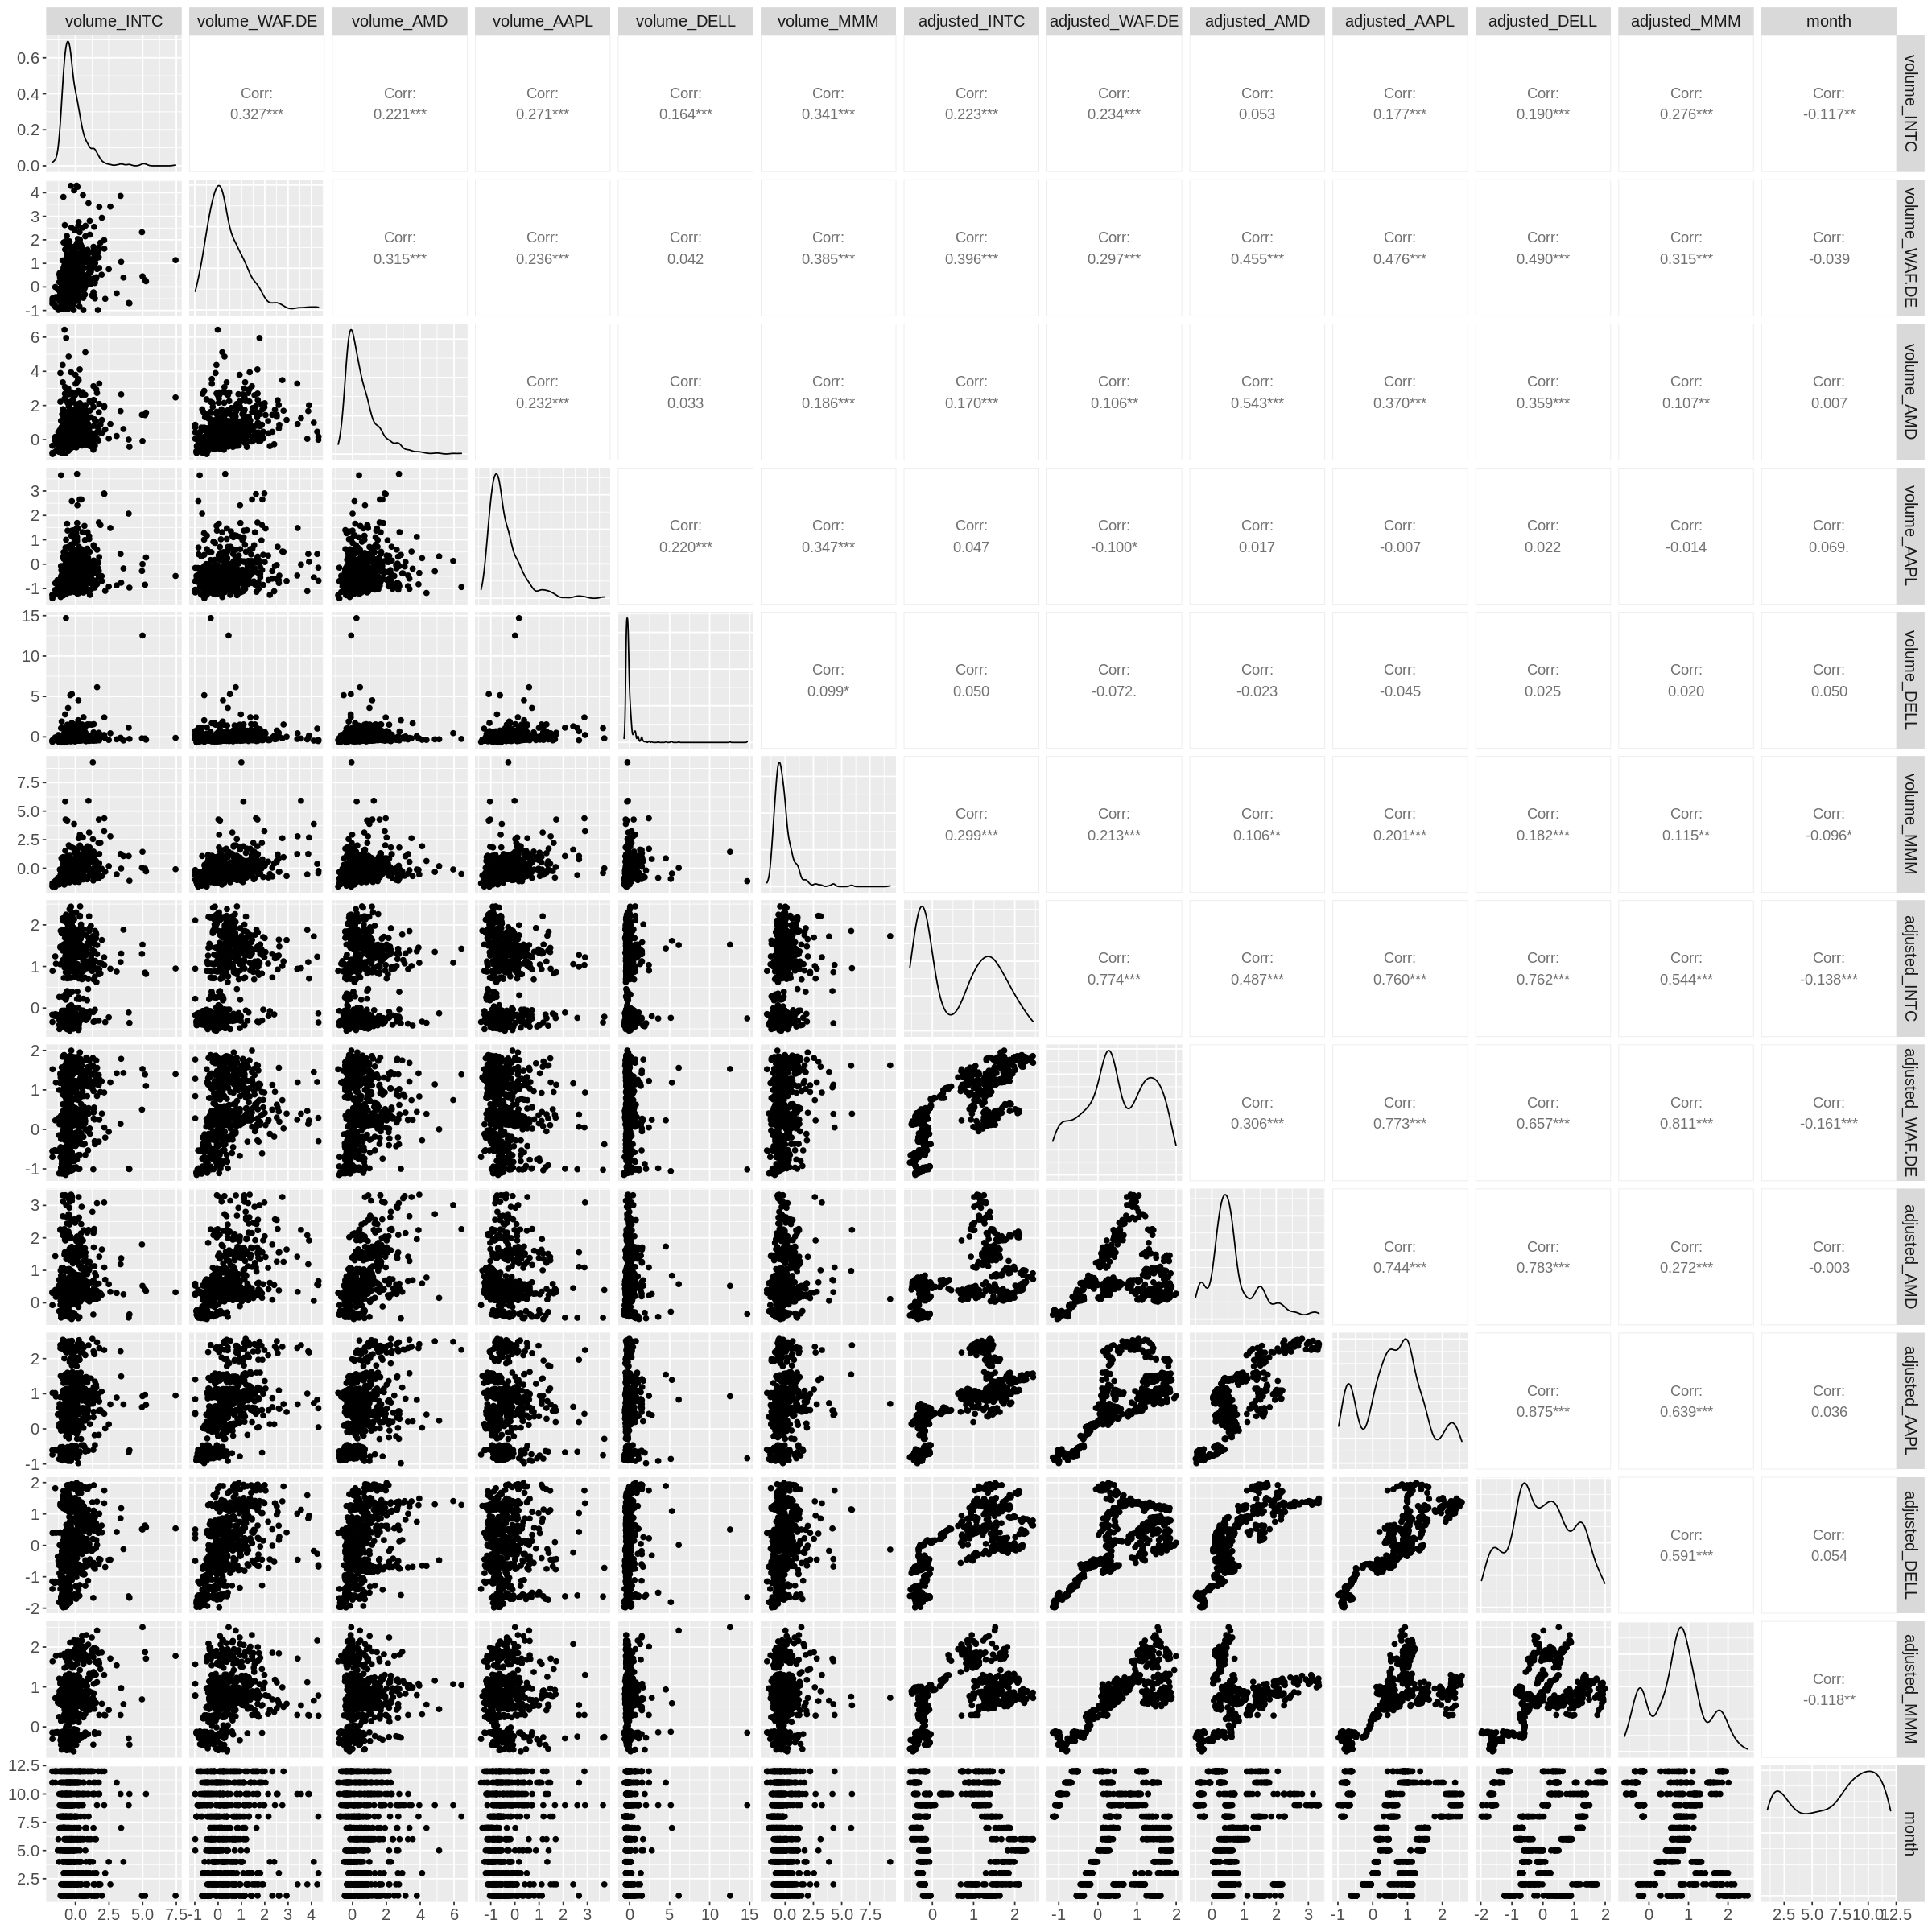

In [11]:
options(repr.plot.width = 20, repr.plot.height = 20)
index_correlation

In [12]:
corr_matrix_intel_index = intel_index[,2:14] |> 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
volume_INTC,volume_INTC,1.0000000
volume_INTC,volume_WAF.DE,0.3267748
volume_INTC,volume_AMD,0.2208188
volume_INTC,volume_AAPL,0.2705980
volume_INTC,volume_DELL,0.1637125
volume_INTC,volume_MMM,0.3408917


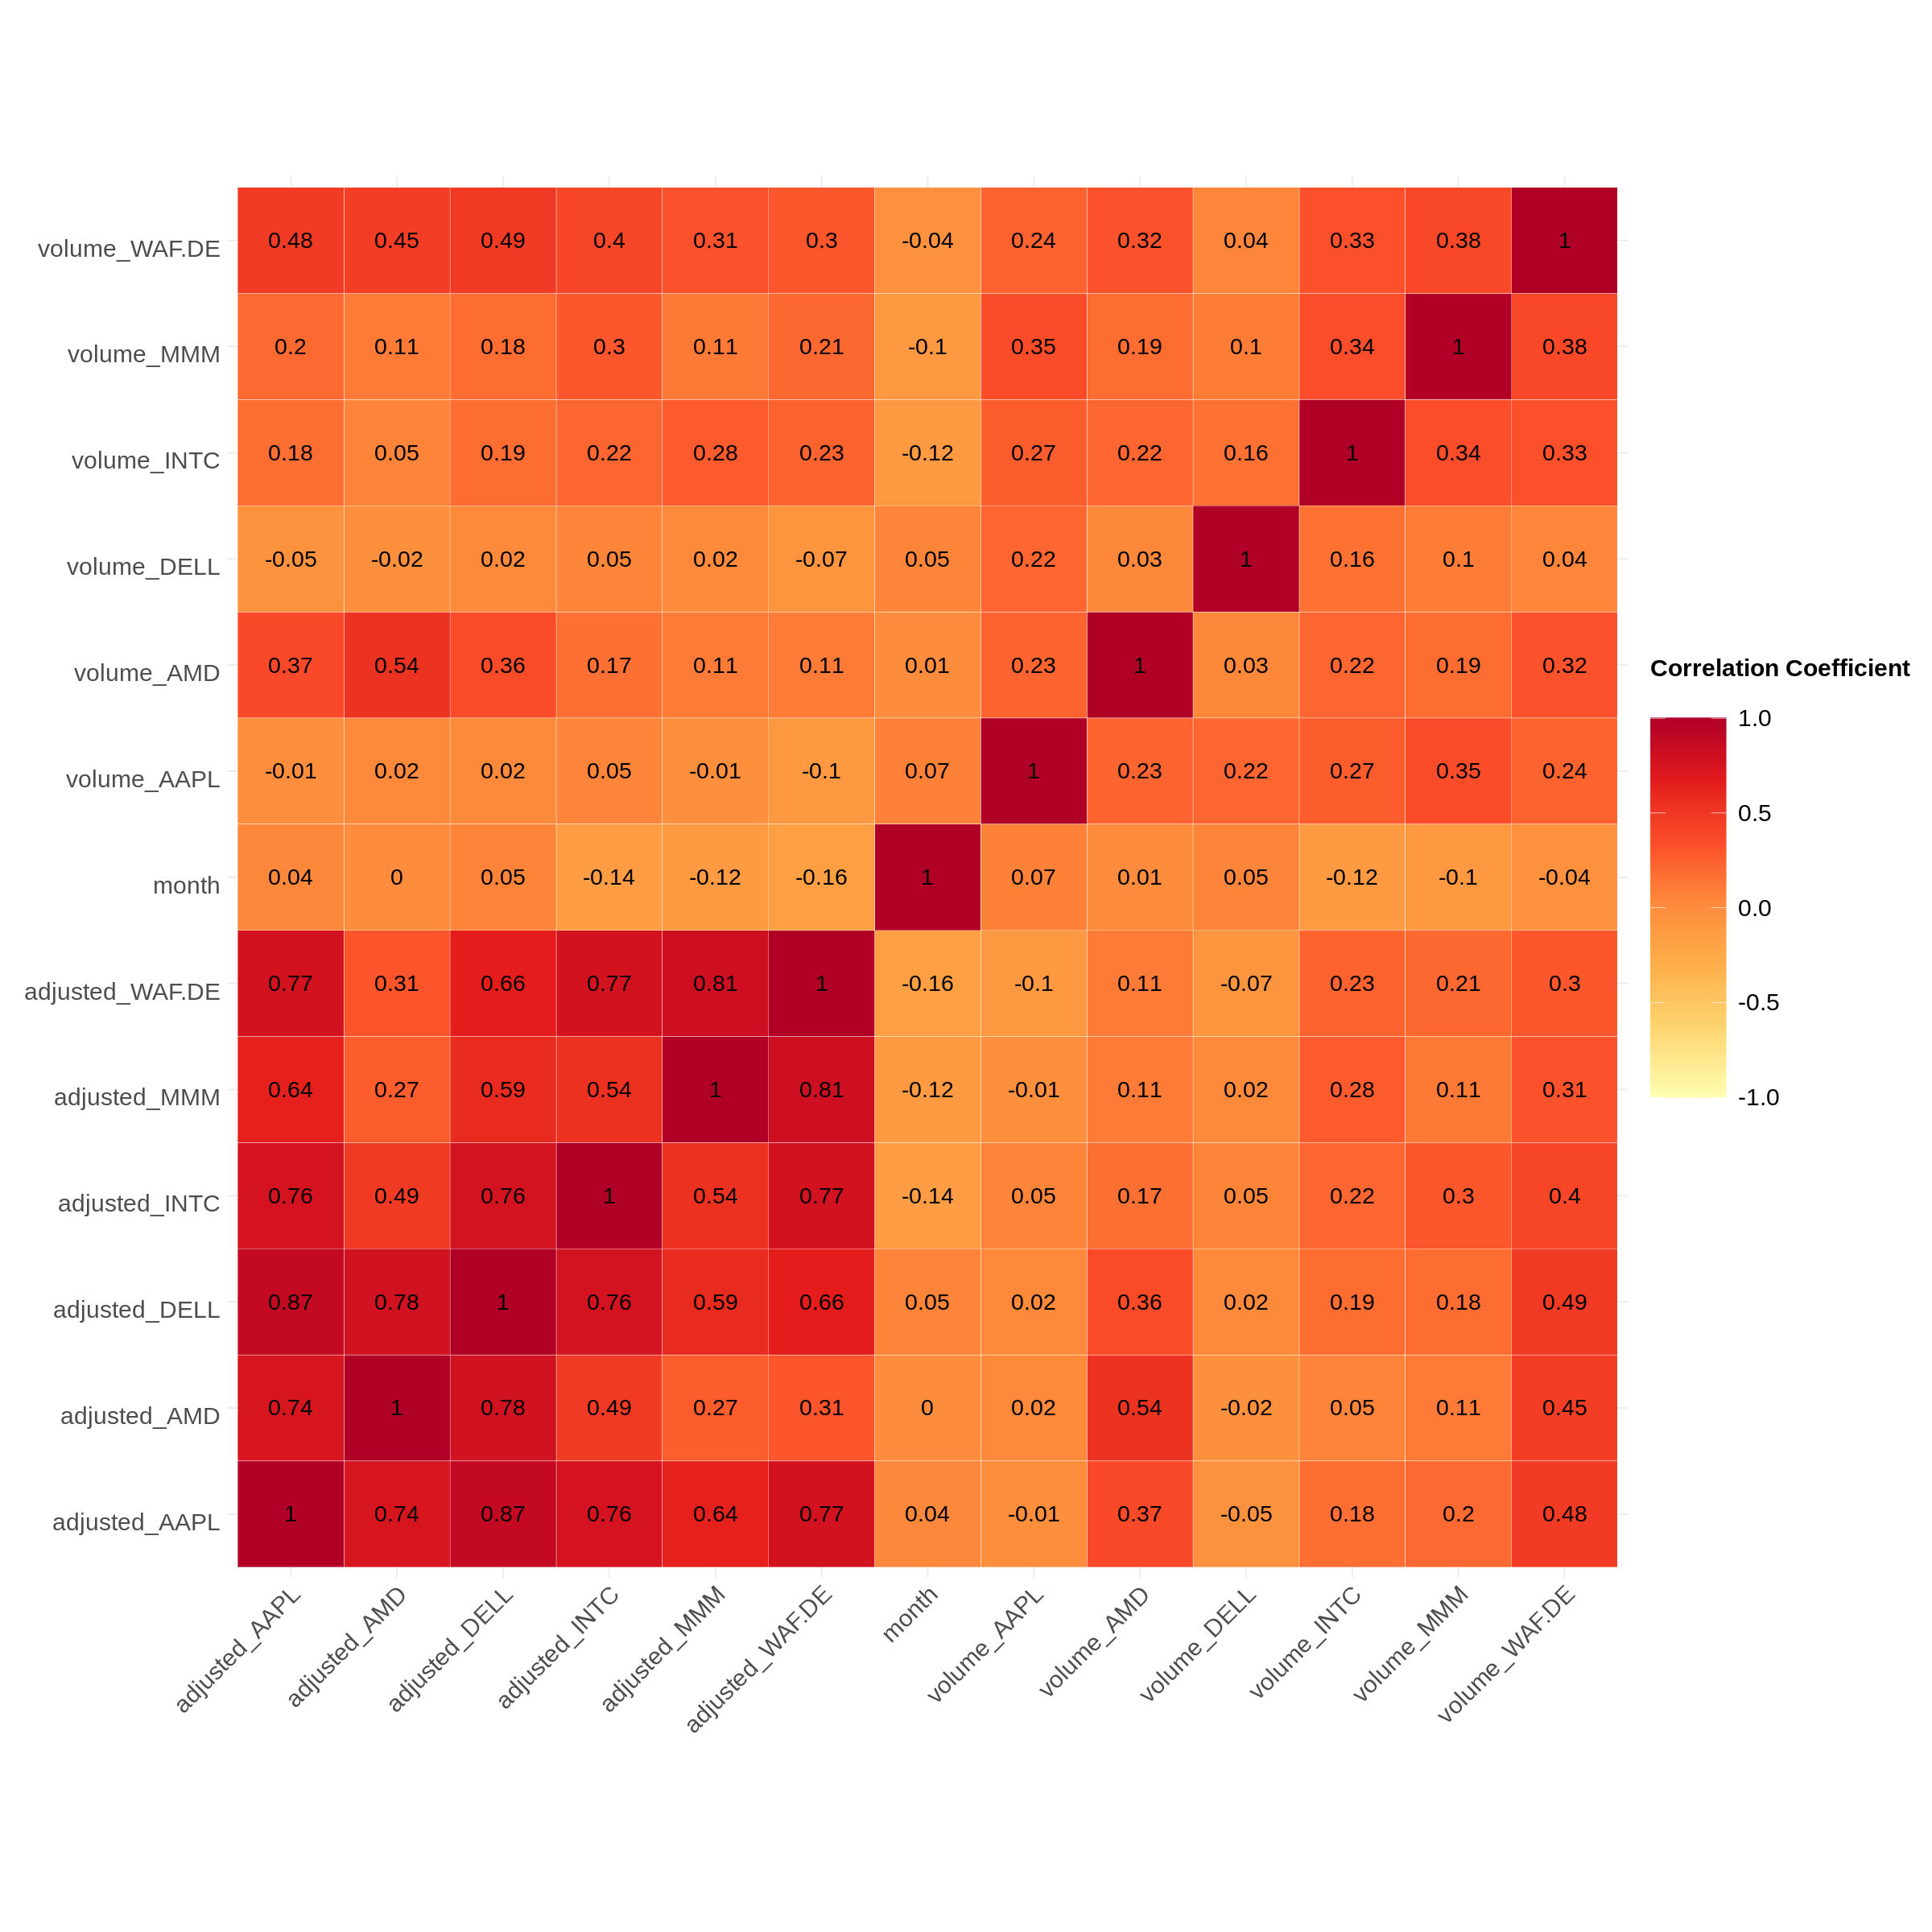

In [13]:
plt_index_corr_matrix <- corr_matrix_intel_index %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 6)
plt_index_corr_matrix

As we see above, there are several variables with high multicollinarity. This is not surprising as this data quantify essentially the same thing over different periods of time. We should account for this with Ridge Linear model. ... With this in mind, we will gather more data that assess the performance of supply chain.

In [14]:
corr_matrix_intel_index <- intel_index %>%
  ungroup() %>%
  select(
      adjusted_INTC, volume_INTC,
      adjusted_AAPL, volume_AAPL,
      adjusted_AMD, volume_AMD,
      adjusted_DELL, volume_DELL,
      adjusted_MMM, volume_MMM,
      adjusted_WAF.DE, volume_WAF.DE,
      month
  ) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
adjusted_INTC,adjusted_INTC,1.00000000
adjusted_INTC,volume_INTC,0.22270740
adjusted_INTC,adjusted_AAPL,0.76015234
adjusted_INTC,volume_AAPL,0.04650217
adjusted_INTC,adjusted_AMD,0.48733097
adjusted_INTC,volume_AMD,0.16958485


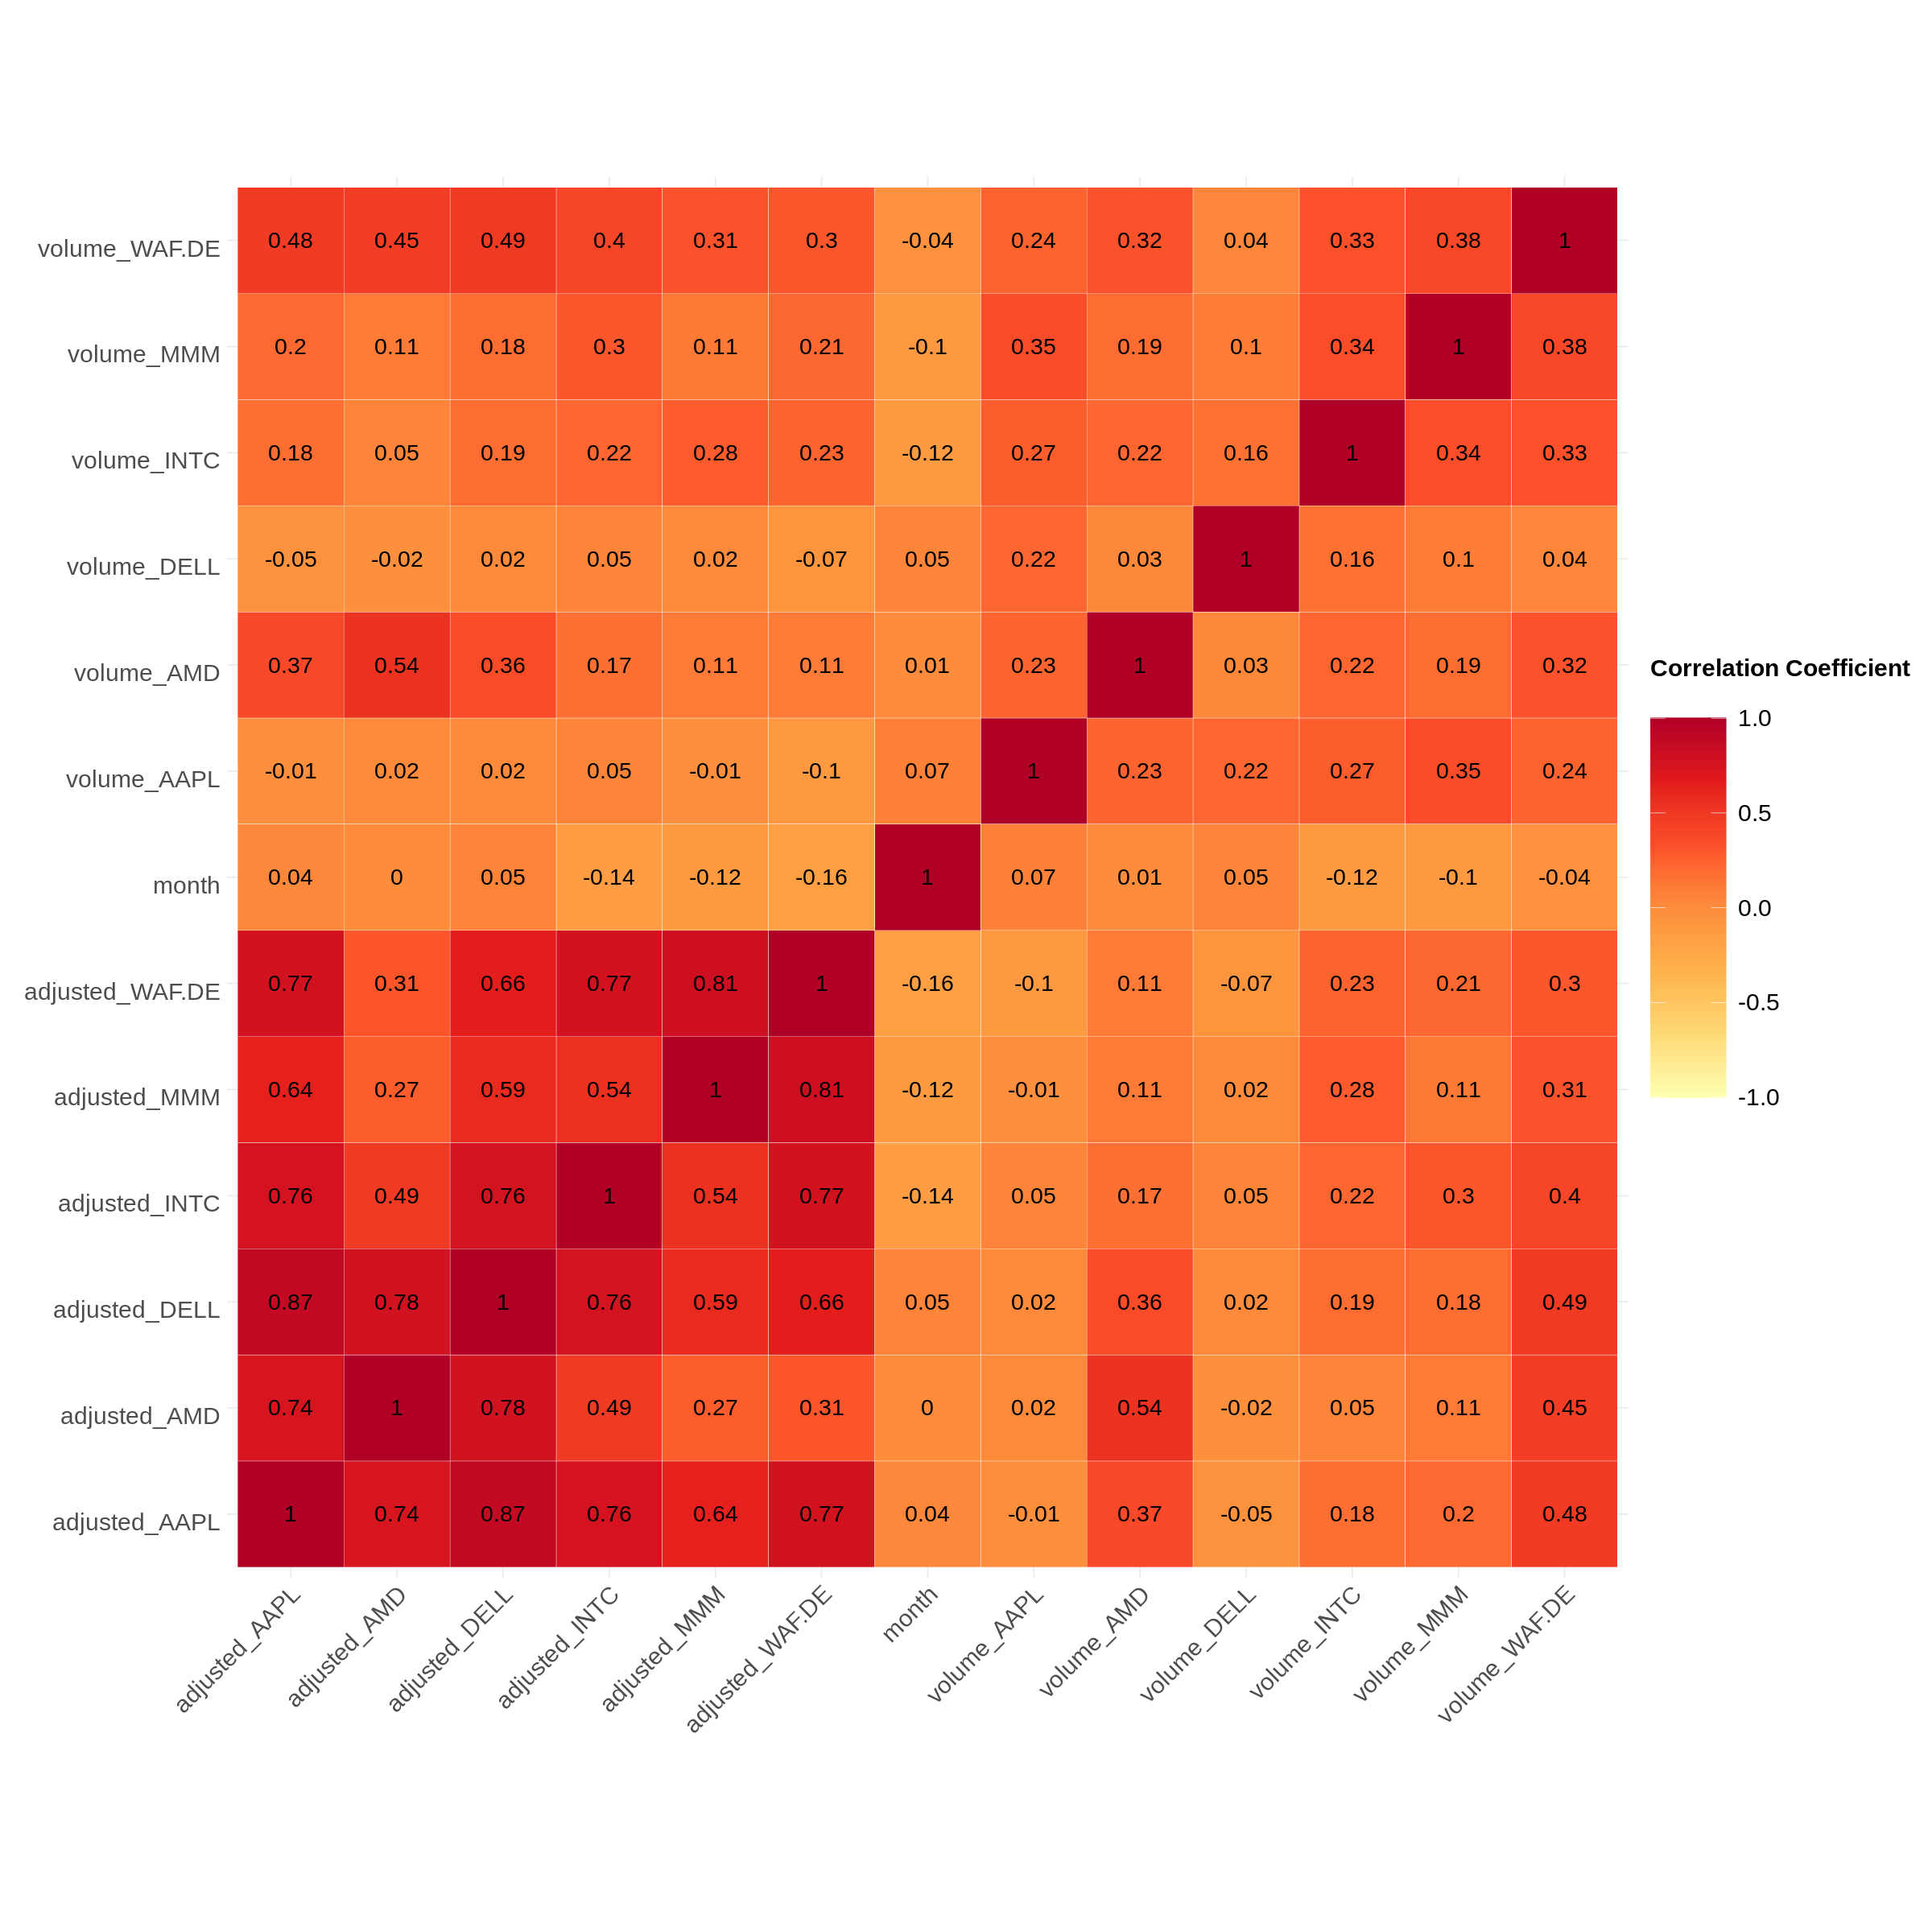

In [15]:
plt_index_corr_matrix <- corr_matrix_intel_index %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 6)
plt_index_corr_matrix

### Methods: Plan

***!!!DELETE***

The previous sections will carry over to your final report (you’ll be allowed to improve them based on feedback you get). Begin this Methods section with a brief description of “the good things” about this report – specifically, in what ways is this report trustworthy?

Finish this section by reflecting on how your final report might play out:

What methods do you plan on using?
What do you expect to achieve?
What impact could your results have?

### References

***!!!DELETE***

At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.